In [1]:
from langchain_community.document_loaders import DirectoryLoader

In [13]:
# Load env
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
loader = DirectoryLoader('data', glob="**/*.txt")
docs = loader.load()

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

In [5]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [6]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
counts = [num_tokens_from_string(t) for t in texts]

<function matplotlib.pyplot.show(close=None, block=None)>

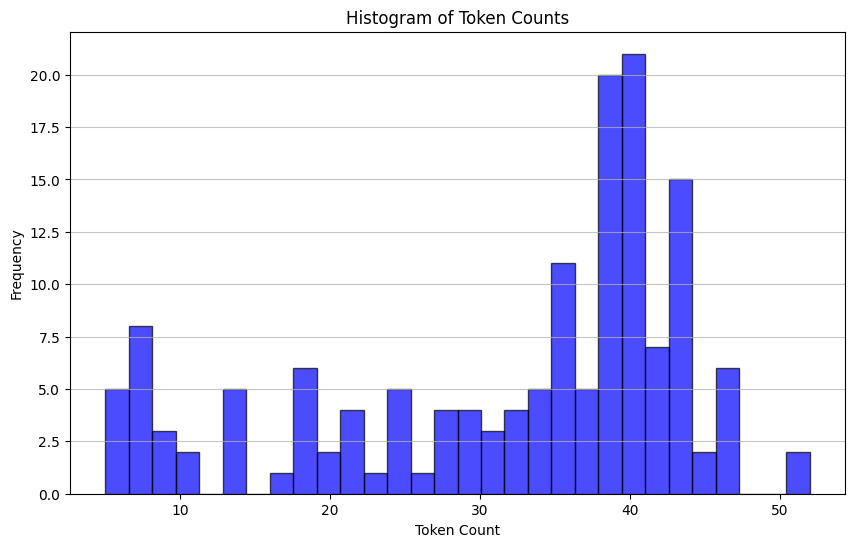

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [11]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5250


In [14]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [15]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]

In [16]:
global_embeddings[0]

[0.021506683218157015,
 -0.016036852211368236,
 0.002706634727711498,
 -0.029704775428179505,
 -0.003430289404524178,
 0.027868190446476968,
 -0.03154136040988204,
 -0.014173650029022978,
 -0.012357027016479857,
 -0.016369567219402255,
 -0.002966152201147377,
 0.004877598758149537,
 -0.011012859315345043,
 -0.03114210426288647,
 0.012084200709891961,
 -0.002204235298410785,
 0.01695514563354213,
 -0.012004349107963797,
 0.01848563280785337,
 -0.0037496955794061805,
 -0.025925134799558294,
 0.013335208208777248,
 -0.0035267767568540435,
 0.012776247926602723,
 -0.006438030748845151,
 -0.005629534210645109,
 0.008337832513396778,
 -0.022305199237438664,
 -0.003922707150753214,
 0.014932239316017917,
 -0.014639450108947981,
 -0.015837223206547825,
 -0.013707849017775352,
 -0.02978462703010767,
 -0.0016577513633762207,
 -0.029305517418538683,
 0.0026284467008235034,
 -0.009761851816459756,
 0.01577068020494102,
 0.0047877657059803526,
 0.002665045351707246,
 -0.00716002185061766,
 -0.00433

In [17]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]



/Users/tapiwamaruni/anaconda3/envs/ragraptor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([10.051315, 11.555645], dtype=float32)

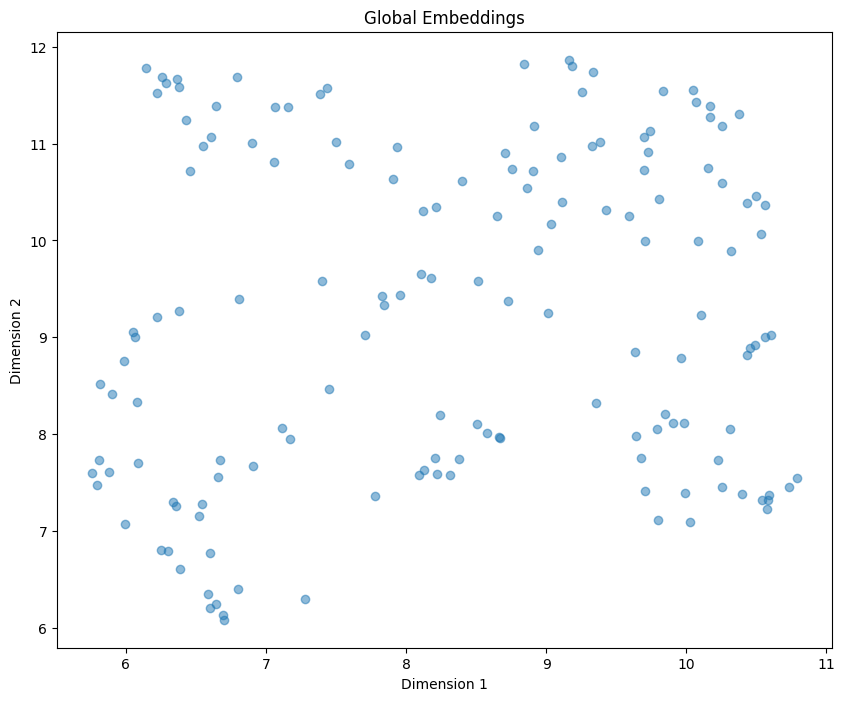

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

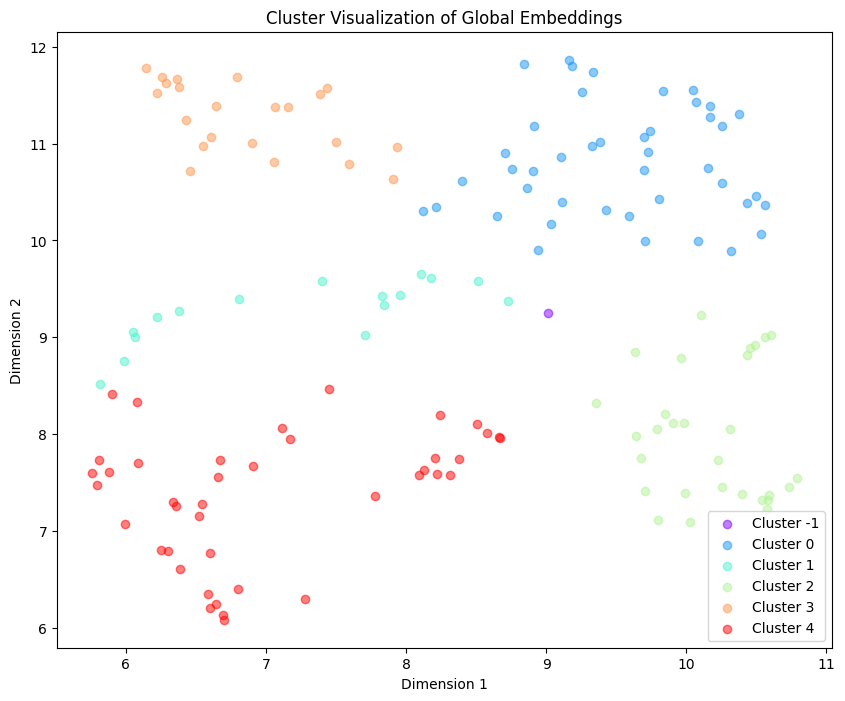

In [20]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [21]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text               Embedding  \
0  Step into our Tuscan-inspired sanctuary, where...  [10.051315, 11.555645]   
1  Tuscany, renowned for its breathtaking country...   [10.069971, 11.43353]   
2  Begin your journey with an antipasto platter a...   [6.896829, 11.004116]   

   Cluster  
0        0  
1        0  
2        3  


In [22]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [23]:
clustered_texts = format_cluster_texts(df)

In [24]:
clustered_texts

{0: "Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany, --- Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore. --- tells a story of generations past, of farmers and artisans who have perfected their craft over centuries. --- Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul, --- both body and soul, offering a taste of Tuscan tradition with every spoonful. --- dish celebrates the region's abundant seafood while paying homage to the fishermen who have sustained generations with their daily catch. --- From the fields to the table, every aspect of Tuscan cuisine speaks to a deep connection to the land and a reverence fo

In [25]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [26]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary


In [27]:
summaries

{0: "The text describes a culinary journey through various regions of Italy, highlighting the rich culinary heritage and traditions that have been passed down through generations. From the sun-kissed landscapes of Tuscany to the bustling streets of Rome and the tranquil waters of Venice, each region offers a unique dining experience that celebrates the flavors, ingredients, and cultural influences that define Italian cuisine.\n\nThe text emphasizes the importance of tradition, flavor, and the soulful spirit of Italian cuisine, showcasing dishes that pay homage to the land, the sea, and the artisans who have perfected their craft over centuries. From hearty vegetable soups in Tuscany to bold Mediterranean flavors in Naples, each dish tells a story of cultural exchange, innovation, and a deep connection to the ingredients that define each region.\n\nThe menu invites diners to experience the true essence of Italian hospitality, where every dish is a celebration of tradition, flavor, and t

In [28]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [29]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [30]:
clustered_summaries

{0: ["The text describes a culinary journey through various regions of Italy, highlighting the rich culinary heritage and traditions that have been passed down through generations. From the sun-kissed landscapes of Tuscany to the bustling streets of Rome and the tranquil waters of Venice, each region offers a unique dining experience that celebrates the flavors, ingredients, and cultural influences that define Italian cuisine.\n\nThe text emphasizes the importance of tradition, flavor, and the soulful spirit of Italian cuisine, showcasing dishes that pay homage to the land, the sea, and the artisans who have perfected their craft over centuries. From hearty vegetable soups in Tuscany to bold Mediterranean flavors in Naples, each dish tells a story of cultural exchange, innovation, and a deep connection to the ingredients that define each region.\n\nThe menu invites diners to experience the true essence of Italian hospitality, where every dish is a celebration of tradition, flavor, and 

In [31]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [32]:
final_summaries

{0: "The text provides a detailed summary of a culinary journey through various regions of Italy, highlighting the rich culinary heritage and traditions that have been passed down through generations. It emphasizes the importance of tradition, flavor, and the soulful spirit of Italian cuisine, showcasing dishes that pay homage to the land, the sea, and the artisans who have perfected their craft over centuries. The menu invites diners to experience the true essence of Italian hospitality, where every dish is a celebration of tradition, flavor, and the timeless beauty of Italy. The text also describes Bella Vista, a restaurant that celebrates the vibrant flavors, fresh ingredients, and time-honored traditions of Italian cuisine, inspired by various regions of Italy. The restaurant prides itself on sourcing the finest seasonal ingredients from local farmers, fishermen, and artisans to create dishes that reflect the essence of Italian cuisine. Giovanni, the visionary behind Bella Vista, i

In [33]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [34]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)


In [35]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 4)


In [36]:
final_number

157

In [37]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [38]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [40]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")

'Giovanni Di Napoli is the owner of the restaurant, Bella Vista.'